**Import Libraries**

---

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import torch.nn as nn
import torch
from torchvision import transforms
import torchvision

import PIL.Image
from PIL import Image

from google.colab import files

import os
import inspect #inspect.getsource(transformers.CLIPProcessor)
import requests


from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import CLIPModel, CLIPTokenizerFast
from transformers.modeling_outputs import BaseModelOutputWithPooling
from transformers.models.clip.modeling_clip import (
    CLIPTextEmbeddings,
    CLIPEncoder,
    CLIPTextConfig
)
from tqdm import tqdm

from transformers.modeling_attn_mask_utils import _prepare_4d_attention_mask, _create_4d_causal_attention_mask
from transformers.models.clip.modeling_clip import CLIPOutput, clip_loss

#from google.colab import drive
#drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cpu


In [ ]:
#!pip freeze > requirements.txt
#!cat requirements.txt

**Import Dataset from Kaggle**

---

takes 17min

In [ ]:
!pip install kaggle
files.upload() # must upload kaggle key

os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c h-and-m-personalized-fashion-recommendations
!unzip -q h-and-m-personalized-fashion-recommendations.zip

Saving kaggle.json to kaggle.json
100% 28.7G/28.7G [07:47<00:00, 211MB/s]
100% 28.7G/28.7G [07:47<00:00, 65.9MB/s]


#Basic model
model for predicting type, for example tshirt or pants 131 classes.

**Load CLIP Model**

---



In [ ]:
# apply model
model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print(processor.image_processor)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}



**Load Text Inputs**

---



In [ ]:
df = pd.read_csv('/content/articles.csv')
#print(df.head)
article_id = df['article_id']
print(len(article_id)) # 105542 articles

prod_type = df['product_type_name']
unique_classes = list(set(prod_type))
print(len(unique_classes), unique_classes) # tshirt osv

possible_classes = [f"an image of a piece of clothing of type {obj}" for obj in unique_classes]
#print(possible_classes)

105542
131 ['Wood balls', 'Kids Underwear top', 'Leg warmers', 'Outdoor overall', 'Cap', 'Skirt', 'Baby Bib', 'Heeled sandals', 'Sandals', 'Weekend/Gym bag', 'Tie', 'Felt hat', 'Sweater', 'Underwear set', 'Flip flop', 'Costumes', 'Dog Wear', 'Swimwear set', 'Boots', 'Soft Toys', 'Sarong', 'Jacket', 'Ring', 'T-shirt', 'Hair/alice band', 'Earrings', 'Slippers', 'Side table', 'Robe', 'Braces', 'Hat/beanie', 'Pre-walkers', 'Outdoor Waistcoat', 'Stain remover spray', 'Earring', 'Pumps', 'Chem. cosmetics', 'Top', 'Headband', 'Bag', 'Hoodie', 'Nipple covers', 'Vest top', 'Ballerinas', 'Bodysuit', 'Unknown', 'Underwear body', 'Toy', 'Cardigan', 'Flat shoes', 'Bucket hat', 'Hairband', 'Gloves', 'Bra', 'Trousers', 'Shorts', 'Mobile case', 'Belt', 'Beanie', 'Other accessories', 'Bumbag', 'Hair clip', 'Socks', 'Blouse', 'Cross-body bag', 'Towel', 'Swimwear top', 'Straw hat', 'Watch', 'Shirt', 'Other shoe', 'Blazer', 'Pyjama set', 'Necklace', 'Washing bag', 'Swimsuit', 'Sleep Bag', 'Wallet', 'Giftb

**Load Image Inputs**

---



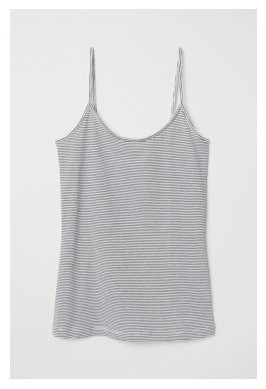

In [ ]:
def get_image(id):
  #id in file is 9 digits and 10 in folder names, add 0
  return PIL.Image.open(f"/content/images/0{str(id)[0:2]}/0{id}.jpg")

id = article_id[2] # change what article out of 105542
image = get_image(id)
plt.imshow(image), plt.axis('off')
plt.show()


**Calculate Simalrity between Classes and Images**:

---


In [ ]:
with torch.no_grad():
    inputs = processor(text=possible_classes, images=image, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
dot_products_per_image = outputs.logits_per_image
#dot_products_per_text = outputs.logits_per_text
probabilities = dot_products_per_image.softmax(dim=1)
#print(probabilities)

**Prediction**

---



In [ ]:
best_index = torch.argmax(probabilities).item()
print('True:', prod_type[article_id == id].values[0])
print('Predict:', unique_classes[best_index])

sorted = torch.argsort(probabilities).numpy().flatten()[::-1]
most_simmilar = [unique_classes[i] for i in sorted]
print(most_simmilar)

True: Vest top
Predict: Vest top
['Vest top', 'Clothing mist', 'Dungarees', 'Swimwear top', 'Outdoor overall', 'Top', 'Shirt', 'Kids Underwear top', 'T-shirt', 'Long John', 'Outdoor Waistcoat', 'Jumpsuit/Playsuit', 'Bodysuit', 'Pyjama jumpsuit/playsuit', 'Mobile case', 'Swimsuit', 'Shorts', 'Pre-walkers', 'Unknown', 'Waterbottle', 'Other accessories', 'Swimwear set', 'Fine cosmetics', 'Cap', 'Tote bag', 'Backpack', 'Beanie', 'Garment Set', 'Braces', 'Cap/peaked', 'Sleep Bag', 'Ballerinas', 'Pyjama set', 'Weekend/Gym bag', 'Tailored Waistcoat', 'Bra extender', 'Alice band', 'Wedge', 'Cardigan', 'Giftbox', 'Dress', 'Blouse', 'Baby Bib', 'Sweater', 'Bra', 'Headband', 'Shoulder bag', 'Chem. cosmetics', 'Hair/alice band', 'Bikini top', 'Accessories set', 'Dog wear', 'Dog Wear', 'Pyjama bottom', 'Bag', 'Underdress', 'Towel', 'Swimwear bottom', 'Bumbag', 'Hoodie', 'Sneakers', 'Washing bag', 'Belt', 'Toy', 'Underwear set', 'Sleeping sack', 'Nipple covers', 'Bucket hat', 'Night gown', 'Tie', 'C

##Testing on a smaller dataset

###First case to see the probabilities of classes

In [ ]:
! kaggle datasets download -d karakaggle/kaggle-cat-vs-dog-dataset
! unzip -q kaggle-cat-vs-dog-dataset.zip -d ./data

Dataset URL: https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset
License(s): unknown
 99% 782M/787M [00:11<00:00, 138MB/s]
100% 787M/787M [00:11<00:00, 69.5MB/s]


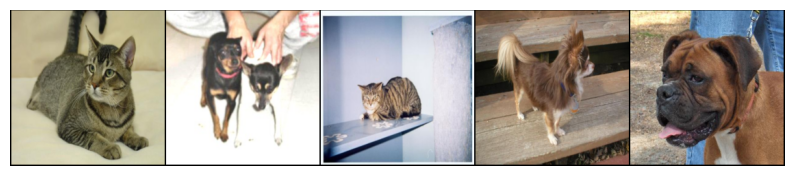

['monster', 'cat', 'dog', 'banana', 'house']
[[0.006 0.986 0.008 0.    0.   ]
 [0.014 0.01  0.976 0.    0.001]
 [0.008 0.981 0.009 0.    0.002]
 [0.008 0.022 0.968 0.001 0.   ]
 [0.021 0.001 0.977 0.    0.   ]]


In [ ]:
def show_images(X):
    np_images = X.numpy()
    plt.figure(figsize=(10, 10))
    grid_img = torchvision.utils.make_grid(torch.tensor(np_images))
    plt.imshow(np.transpose(grid_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()
class CatsAndDogsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, category in enumerate(['Cat', 'Dog']):
            category_dir = os.path.join(root_dir, category)
            for img_name in os.listdir(category_dir):
                img_path = os.path.join(category_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor.feature_extractor.do_rescale = False # make sure image values: False=> [0-1] and True=> [0,255]

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Model expect this mormate
    transforms.ToTensor()])

dataset = CatsAndDogsDataset(root_dir='./data/kagglecatsanddogs_3367a/PetImages', transform=transform)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)
classes=['monster', 'cat', 'dog', 'banana', 'house'] # predictable classes
plot = True
with torch.no_grad():
    for images, labels in dataloader:
        labels = ['An image of a '+i for i in classes]
        outputs = model(**processor(text=labels, images=images, return_tensors="pt", padding=True, truncation=True))
        probs = outputs.logits_per_image.softmax(dim=-1).cpu().numpy()
        if plot:
            show_images(images)
            print(classes)
            print(probs.round(decimals=3))
        break


### Using original clip and making sure that it gets the same as hugging face OBS!


processor.feature_extractor.do_rescale = False


make sure image values is in correct format: False=> [0-1] and True=> [0,255]

In [ ]:
! pip install ftfy regex tqdm -q
! pip install git+https://github.com/openai/CLIP.git -q

ERROR: Operation cancelled by user
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 1.9 MB/s eta 0:00:00


['An image of a monster', 'An image of a cat', 'An image of a dog', 'An image of a banana', 'An image of a house']


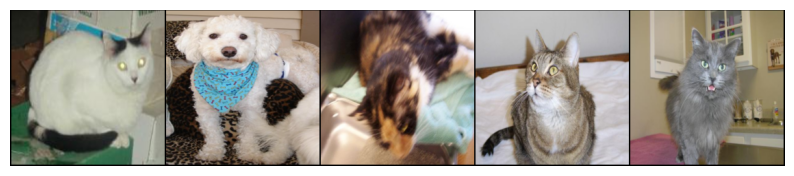

[[0.039 0.952 0.007 0.001 0.   ]
 [0.015 0.01  0.974 0.    0.001]
 [0.024 0.892 0.079 0.002 0.002]
 [0.017 0.972 0.01  0.    0.   ]
 [0.058 0.926 0.016 0.    0.   ]]


In [ ]:
import clip
model, preprocess = clip.load("ViT-B/32", device=device)
with torch.no_grad():
  for image, labels in dataloader:
    text = ['An image of a '+i for i in classes]
    print(text)
    text = clip.tokenize(text)
    show_images(image)
    #image = preprocess(image)
    logits_per_image, logits_per_text = model(image.to(device), text.to(device))
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    print(probs.round(decimals=3))
    break

### Eval on whole dataset

Apply transform at the start

  0%|          | 0/624 [00:00<?, ?it/s]<ipython-input-15-ab0fd344d837>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images[0]).to(device)


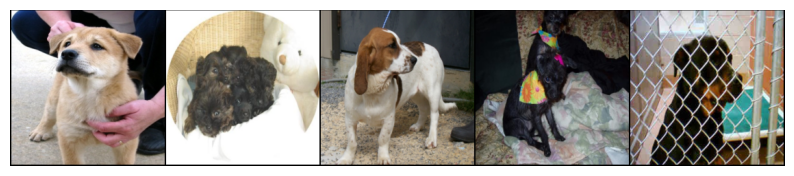

  0%|          | 1/624 [00:32<5:38:07, 32.56s/it]

tensor([1, 1, 1, 1, 1])
['cat', 'dog', 'apple', 'elephant']
[[0.003 0.997 0.    0.   ]
 [0.033 0.963 0.002 0.002]
 [0.002 0.997 0.    0.   ]
 [0.043 0.956 0.001 0.   ]
 [0.026 0.941 0.001 0.032]]


  0%|          | 2/624 [01:01<5:20:37, 30.93s/it]


KeyboardInterrupt: 

In [ ]:
class CatsAndDogsDataset(Dataset):
    def __init__(self, root_dir, processor, transform):
        self.root_dir = root_dir
        self.processor = processor
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for label, category in enumerate(['Cat', 'Dog']):
            category_dir = os.path.join(root_dir, category)
            for img_name in os.listdir(category_dir):
                img_path = os.path.join(category_dir, img_name)
                if img_name.endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        image = self.transform(image)
        image = self.processor(images=image)['pixel_values']
        return image, label

model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)

processor.feature_extractor.do_rescale = False # make sure image values: False=> [0-1] and True=> [0,255]

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Model expect this formate
    transforms.ToTensor()])

dataset = CatsAndDogsDataset(root_dir='./data/kagglecatsanddogs_3367a/PetImages', processor=processor, transform=transform)
dataloader = DataLoader(dataset, batch_size=40, shuffle=True)

plot = True
class_id2name = ['cat', 'dog', 'apple', 'elephant'] # predictable classes, two dummy
class_id = torch.arange(0,len(class_id2name))

all_predictions = []
all_labels = []
with torch.no_grad():
    for batch_nr, (images, labels) in enumerate(tqdm(dataloader)):
        text = ['An image of a '+i for i in class_id2name]
        images = torch.tensor(images[0]).to(device)
        text = processor(text=text, return_tensors="pt", padding=True, truncation=True)
        outputs = model(pixel_values=images, input_ids = text['input_ids'].to(device), attention_mask=text['attention_mask'].to(device))
        if plot and batch_nr%20==0:
            probs = outputs.logits_per_image.softmax(dim=-1).cpu().numpy()
            mean = torch.tensor(processor.feature_extractor.image_mean).view(1, 3, 1, 1)# only colour channels
            std = torch.tensor(processor.feature_extractor.image_std).view(1, 3, 1, 1)
            images = images.cpu() * std + mean  # Add back the normalization
            show_images(images[0:5,:,:,:])# do not show all
            print(labels[0:5])
            print(class_id2name)
            print(probs.round(decimals=3)[0:5,:])

        predicted_class = outputs.logits_per_image.argmax(dim=-1)

        all_predictions.append(predicted_class)
        all_labels.append(labels)

In [ ]:
all_predictions_=torch.cat(all_predictions).cpu()
all_labels_=torch.cat(all_labels).cpu()
from sklearn.metrics import classification_report
print(classification_report(all_labels_, all_predictions_))
correct = all_predictions_==all_labels_
print(f'accuracy {100*correct.sum()/correct.shape[0]} %')

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        39
           1       0.98      1.00      0.99        41

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

accuracy 98.75 %


99.5% is way to high accuracy to be finetuned

##Testing on larger

First make dataset

In [ ]:
class HMDataset(Dataset):
    """Loading data from HM file, use dataloader to acces item"""
    def __init__(self, articles_csv, image_dir, category, processor, transform=None):
        # Load the CSV files
        self.articles = pd.read_csv(articles_csv)

        # Image directory
        self.image_dir = image_dir
        self.processor = processor
        self.transform = transform

        self.main_class = category #for example prod_name
        self.id_add = 0 # take next if image does not exist
        self.len = self.articles.shape[0]

        self.main_classes=self.articles.columns
        self.sub_classes = list(self.articles[self.main_class].unique())
        self.count_sub_classes = self.articles[self.main_class].value_counts()

        self.class_to_id = {name: i for i, name in enumerate(self.sub_classes)}

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        id =self.articles['article_id'][idx]
        label = self.articles[self.main_class][idx]
        image_path = f"{self.image_dir}/0{str(id)[0:2]}/0{id}.jpg"
        try:
            image = Image.open(image_path)
            transform = transforms.ToTensor()
            image_tensor = transform(image)
            image_input = self.processor(images=image_tensor, return_tensors="pt")['pixel_values'].squeeze(0)
            return image_input, label

        except FileNotFoundError:
            print(f"Image for article {id} not found. Takes next")
            self.id_add +=1
            self.len-=1
            return self.__getitem__(idx+self.id_add)

Make loop without first

['Vest top', 'Bra', 'Underwear Tights', 'Socks', 'Leggings/Tights', 'Sweater', 'Top', 'Trousers', 'Hair clip', 'Umbrella', 'Pyjama jumpsuit/playsuit', 'Bodysuit', 'Hair string', 'Unknown', 'Hoodie', 'Sleep Bag', 'Hair/alice band', 'Belt', 'Boots', 'Bikini top', 'Swimwear bottom', 'Underwear bottom', 'Swimsuit', 'Skirt', 'T-shirt', 'Dress', 'Hat/beanie', 'Kids Underwear top', 'Shorts', 'Shirt', 'Cap/peaked', 'Pyjama set', 'Sneakers', 'Sunglasses', 'Cardigan', 'Gloves', 'Earring', 'Bag', 'Blazer', 'Other shoe', 'Jumpsuit/Playsuit', 'Sandals', 'Jacket', 'Costumes', 'Robe', 'Scarf', 'Coat', 'Other accessories', 'Polo shirt', 'Slippers', 'Night gown', 'Alice band', 'Straw hat', 'Hat/brim', 'Tailored Waistcoat', 'Necklace', 'Ballerinas', 'Tie', 'Pyjama bottom', 'Felt hat', 'Bracelet', 'Blouse', 'Outdoor overall', 'Watch', 'Underwear body', 'Beanie', 'Giftbox', 'Sleeping sack', 'Dungarees', 'Outdoor trousers', 'Wallet', 'Swimwear set', 'Swimwear top', 'Flat shoe', 'Garment Set', 'Ring', 'Wate

  0%|          | 0/17591 [00:00<?, ?it/s]

torch.Size([3, 1750, 1166])
torch.Size([3, 1750, 1166])
torch.Size([3, 1749, 2637])
torch.Size([3, 1750, 1166])
torch.Size([3, 1750, 1166])
torch.Size([3, 1750, 1166])


/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


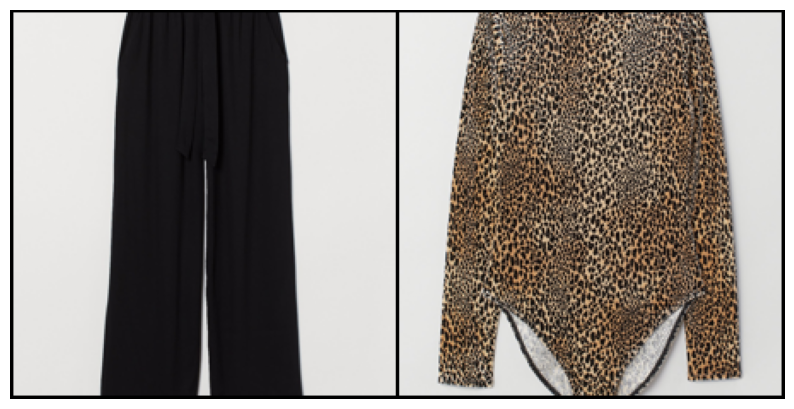

  0%|          | 1/17591 [00:02<11:20:33,  2.32s/it]

('Trousers', 'Vest top', 'Heeled sandals', 'Dress', 'Shirt')
['Vest top', 'Bra', 'Underwear Tights', 'Socks', 'Leggings/Tights', 'Sweater', 'Top', 'Trousers', 'Hair clip', 'Umbrella', 'Pyjama jumpsuit/playsuit', 'Bodysuit', 'Hair string', 'Unknown', 'Hoodie', 'Sleep Bag', 'Hair/alice band', 'Belt', 'Boots', 'Bikini top', 'Swimwear bottom', 'Underwear bottom', 'Swimsuit', 'Skirt', 'T-shirt', 'Dress', 'Hat/beanie', 'Kids Underwear top', 'Shorts', 'Shirt', 'Cap/peaked', 'Pyjama set', 'Sneakers', 'Sunglasses', 'Cardigan', 'Gloves', 'Earring', 'Bag', 'Blazer', 'Other shoe', 'Jumpsuit/Playsuit', 'Sandals', 'Jacket', 'Costumes', 'Robe', 'Scarf', 'Coat', 'Other accessories', 'Polo shirt', 'Slippers', 'Night gown', 'Alice band', 'Straw hat', 'Hat/brim', 'Tailored Waistcoat', 'Necklace', 'Ballerinas', 'Tie', 'Pyjama bottom', 'Felt hat', 'Bracelet', 'Blouse', 'Outdoor overall', 'Watch', 'Underwear body', 'Beanie', 'Giftbox', 'Sleeping sack', 'Dungarees', 'Outdoor trousers', 'Wallet', 'Swimwear se

  0%|          | 2/17591 [00:03<8:56:14,  1.83s/it] 

torch.Size([3, 1750, 1166])
torch.Size([3, 1750, 1166])
torch.Size([3, 1750, 1166])
torch.Size([3, 1750, 1166])
torch.Size([3, 1750, 1166])


  0%|          | 3/17591 [00:05<8:00:31,  1.64s/it]

torch.Size([3, 1750, 1166])
torch.Size([3, 1750, 1166])


  0%|          | 3/17591 [00:05<9:07:07,  1.87s/it]

torch.Size([3, 1750, 1166])


KeyboardInterrupt: 

In [ ]:
image_dir = '/content/images'
model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor.feature_extractor.do_rescale = False # make sure image values: False=> [0-1] and True=> [0,255]
model.to(device)

dataset = HMDataset(
    articles_csv='/content/articles.csv',
    image_dir=image_dir,
    category = 'product_type_name',
    processor=processor)
dataloader = DataLoader(dataset, batch_size=6, shuffle=True)


def return_normal(tensor_image, processor, ant):
    mean = torch.tensor(processor.feature_extractor.image_mean).view(1, 3, 1, 1)# only colour channels
    std = torch.tensor(processor.feature_extractor.image_std).view(1, 3, 1, 1)
    tensor_image = tensor_image.cpu() * std + mean  # Add back the normalization
    show_images(tensor_image[0:ant,:,:,:])# do not show all
#image = dataset[15][0]
#return_normal(image, processor, 1)


classes = dataset.sub_classes
print(classes)
all_predictions = []
all_labels = []
plot = True
with torch.no_grad():
    for batch_nr, (images, labels) in enumerate(tqdm(dataloader)):
        text = ['An image of a '+i for i in classes]
        images = images.to(device)
        text = processor(text=text, return_tensors="pt", padding=True, truncation=True)
        outputs = model(pixel_values=images, input_ids = text['input_ids'].to(device), attention_mask=text['attention_mask'].to(device))
        predicted_class = outputs.logits_per_image.argmax(dim=-1)

        if plot and batch_nr%20==0:
            probs = outputs.logits_per_image.softmax(dim=-1).cpu().numpy()
            return_normal(images, processor, 2)
            print(labels[0:5])
            print(classes)
            print(probs.round(decimals=3)[0:5,:])


        all_predictions.append(predicted_class)
        all_labels.append(torch.tensor([dataset.class_to_id[i] for i in labels]))


Create smaller dataset

In [ ]:
class HMDataset2(Dataset):
    def __init__(self, articles_csv, image_dir, main_class, processor, model, transform=None):
        # Load the CSV files
        self.articles = pd.read_csv(articles_csv)

        # Image directory
        self.image_dir = image_dir # image folder
        self.processor = processor # prcessor of clip model
        self.transform = transforms.ToTensor()
        self.model = model

        self.main_class = main_class #for example prod_name
        self.id_add = 0 # take next if image does not exist
        self.len = self.articles.shape[0]

        self.main_classes=self.articles.columns # all classes
        self.sub_classes = list(self.articles[self.main_class].unique()) # list of all subclasses
        self.count_sub_classes = self.articles[self.main_class].value_counts() # couunts in subclasses

        self.class_to_id = {name: i for i, name in enumerate(self.sub_classes)}

        self.max_counts = 4 # max number of data per class
        self.counts = {name: 0 for name in self.sub_classes} # number of samples each class

        self.processor.feature_extractor.do_rescale = False # # make sure image values: False=> [0-1] and True=> [0,255]


    def __len__(self):
        return self.len

    def get_n_of_each(self, max_counts):
        self.max_counts = max_counts
        all_embeds = []
        all_labels = []
        all_images = []
        for idx in range(self.len):
          id =self.articles['article_id'][idx]
          subclass_name = self.articles[self.main_class][idx]
          if self.counts[subclass_name] < self.max_counts:
              image_path = f"{self.image_dir}/0{str(id)[0:2]}/0{id}.jpg"
              try:
                  image_tensor = self.transform(Image.open(image_path))#.to(device)
                  with torch.no_grad():
                      inp = self.processor(text = 'XX', images=image_tensor, return_tensors="pt", padding=True)
                      image_embeds = self.model(**inp)['image_embeds']
                  self.counts[subclass_name]+=1

                  all_embeds.append(image_embeds)
                  all_labels.append(subclass_name)
                  all_images.append(inp['pixel_values'])
              except FileNotFoundError:
                  print(f"Image for article {id} not found. Takes next")
        return torch.cat(all_embeds), all_labels, torch.cat(all_images)


class CatsAndDogsDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Model expect this formate
    transforms.ToTensor()])
        self.image_paths = []
        self.labels = []

        for label, category in enumerate(['Cat', 'Dog']):
            category_dir = os.path.join(root_dir, category)
            for img_name in os.listdir(category_dir):
                img_path = os.path.join(category_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

class UniformHMDataset(Dataset):
    def __init__(self, emb, labels, image):
      self.emb = emb
      self.labels = labels
      self.image = image
      self.classes = list(set(labels))
      self.class_to_id = {name: i for i, name in enumerate(self.classes)}


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
      return self.emb[idx], self.labels[idx], self.image[idx]

dataset = HMDataset2(
    articles_csv='/content/articles.csv',
    image_dir = '/content/images',
    main_class = 'index_group_name',
    model= transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32"),
    processor=transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32"))

n_samples = 500
image_emb, labels , images = dataset.get_n_of_each(n_samples) # Create uniform dataset

data_to_save = {
    'image_embedding': image_emb,
    'class_text': labels,
    'images': images}
torch.save(data_to_save, f'HM_data_{n_samples}.pth')

dataset = UniformHMDataset(image_emb, labels , images)
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

loaded_data = torch.load(f'HM_data_{n_samples}.pth')
image_emb = loaded_data['image_embedding']
labels = loaded_data['class_text']
images = loaded_data['images']

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Image for article 174057028 not found. Takes next
Image for article 179208001 not found. Takes next
Image for article 212042043 not found. Takes next
Image for article 212042066 not found. Takes next
Image for article 212629004 not found. Takes next
Image for article 215324023 not found. Takes next
Image for article 216961011 not found. Takes next
Image for article 218354021 not found. Takes next
Image for article 241602023 not found. Takes next
Image for article 268305006 not found. Takes next
Image for article 272591001 not found. Takes next
Image for article 324963030 not found. Takes next
Image for article 348657006 not found. Takes next
Image for article 364409037 not found. Takes next
Image for article 369423002 not found. Takes next
Image for article 369423004 not found. Takes next
Image for article 388916001 not found. Takes next
Image for article 396690010 not found. Takes next
Image for article 397376010 not found. Takes next
Image for article 398947001 not found. Takes next


<ipython-input-24-69691471e481>:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(f'HM_data_{n_samples}.pth')
